## 1. Importing Required Libraries  
In this section, we import all required Python libraries for data handling, model training, evaluation, and MLflow experiment tracking.

In [23]:
# Imports
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score

import mlflow
import mlflow.sklearn
from mlflow.tracking import MlflowClient

## 2. Loading the Telecom Customer Churn Dataset  
We load the cleaned telecom churn dataset from a CSV file, then preview the first few rows to verify structure.

In [4]:
# Data Loading
df = pd.read_csv("telecom_customer_churn_clean.csv")
df.head()

,Gender,Age,Married,Number of Dependents,City_0,City_1,City_2,City_3,City_4,City_5,...,Streaming TV,Streaming Movies,Streaming Music,Unlimited Data,Contract,Total Charges,Total Refunds,Total Extra Data Charges,Total Long Distance Charges,Customer Status
0,0,37,1,0,0,0,0,0,0,0,...,1,0,0,1,2,593.30,0.00,0,381.51,0
1,1,46,0,0,0,0,0,0,0,0,...,0,1,1,0,1,542.40,38.33,10,96.21,0
2,1,50,0,0,0,0,0,0,0,0,...,0,0,0,1,1,280.85,0.00,0,134.60,1
3,1,78,1,0,0,0,0,0,0,0,...,1,1,0,1,1,1237.85,0.00,0,361.66,1
4,0,75,1,0,0,0,0,0,0,0,...,1,0,0,1,1,267.40,0.00,0,22.14,1


## Findings from data inspection:
 - Target distribution: ~73% No Churn (0), ~27% Churn (1)
 - All features are numeric 
 - Cleaned file: no missing values, no strings — ready for modeling

## 3. Preparing Features (X) and Target (y)  
We separate the independent variables (X) from the target variable (y), where `Customer Status` indicates whether the customer churned.

In [8]:
# Prepare X, y
X = df.drop(['Customer Status'], axis=1)
y = df['Customer Status']                       # Target

## 4. Splitting the Data (Train/Test Split)  
- Split Before any preprocessing to avoid data leakage
- We use an 80/20 train-test split with stratification to maintain the same churn ratio in both sets.

In [11]:
# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

## 5. Feature Scaling  
We apply StandardScaler to normalize numerical features before training the Gradient Boosting model.

In [14]:
# Scaling Numerical Features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

## 6. MLflow Experiment Tracking Setup  
We configure MLflow to track experiments, models, parameters, and performance metrics.  

In [17]:
# Setup MLflow
mlflow.set_tracking_uri("http://127.0.0.1:5000")
mlflow.set_experiment("Telecom_Churn_GB1")
client = MlflowClient()

# Model name
MODEL_NAME = "Churn_GradientBoosting__"

# MODEL: Gradient Boosting Classifier

## Why Gradient Boosting?
 - Handles mixed feature types well (even though all are numeric here)
 - Robust to outliers and non-linear relationships
 - No need for balancing — we optimize directly for recall (churn detection)

## 7. Baseline Gradient Boosting Model  
We train an initial Gradient Boosting model using default-like parameters for comparison.  
This establishes a baseline accuracy and recall score.

In [31]:
# PART 1: Baseline Model (No GridSearch)
with mlflow.start_run(run_name="Baseline_GB") as run1:
   # Instantiate baseline model
    model_baseline = GradientBoostingClassifier(
        n_estimators=100,
        learning_rate=0.1,
        max_depth=3,
        random_state=42
    )

    # Train
    model_baseline.fit(X_train, y_train)
    
    # Predict & Evaluate
    y_pred = model_baseline.predict(X_test)
    acc = accuracy_score(y_test, y_pred)
    rec = recall_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, average="weighted")
    f1 = f1_score(y_test, y_pred, average="weighted")

    # Log to MLflow
    mlflow.log_param("approach", "baseline")
    mlflow.log_params(model_baseline.get_params())
    mlflow.log_metric("test_accuracy", acc)
    mlflow.log_metric("test_recall_churn", rec)
    mlflow.log_metric("precision", precision)
    mlflow.log_metric("f1_score", f1)
    mlflow.sklearn.log_model(model_baseline, "model")
    
    # Register model
    model_uri = f"runs:/{run1.info.run_id}/model"
    reg_result = mlflow.register_model(model_uri=model_uri, name=MODEL_NAME)
    version_baseline = reg_result.version
    
    # Set alias
    client.set_registered_model_alias(
        name=MODEL_NAME,
        alias="baseline",
        version=version_baseline
    )
    
    print(f"Baseline — Accuracy: {acc:0.2%} | Recall (Churn): {rec:0.2%}")
    print(f"Precision: {precision:0.2%}")
    print(f"F1 Score: {f1:0.2%}")
    print(f"\nRegistered as version {version_baseline}, alias @baseline")

2025/12/09 16:34:47 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/12/09 16:34:54 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
Registered model 'Churn_GradientBoosting__' already exists. Creating a new version of this model...
2025/12/09 16:34:55 WARNING mlflow.tracking._model_registry.fluent: Run with id e27ee29d75374cc69f73d200f59baf55 has no artifacts at artifact path 'model', registering model based on models:/m-8299413a0692414eaaa8c606b6716c56 instead
2025/12/09 16:34:56 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: Churn_GradientBoosting__, version 12
Created version '12' of model 'Churn_GradientBoosting__'.


Baseline — Accuracy: 85.43% | Recall (Churn): 63.90%
Precision: 85.07%
F1 Score: 84.87%

Registered as version 12, alias @baseline
🏃 View run Baseline_GB at: http://127.0.0.1:5000/#/experiments/111232043532942513/runs/e27ee29d75374cc69f73d200f59baf55
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/111232043532942513


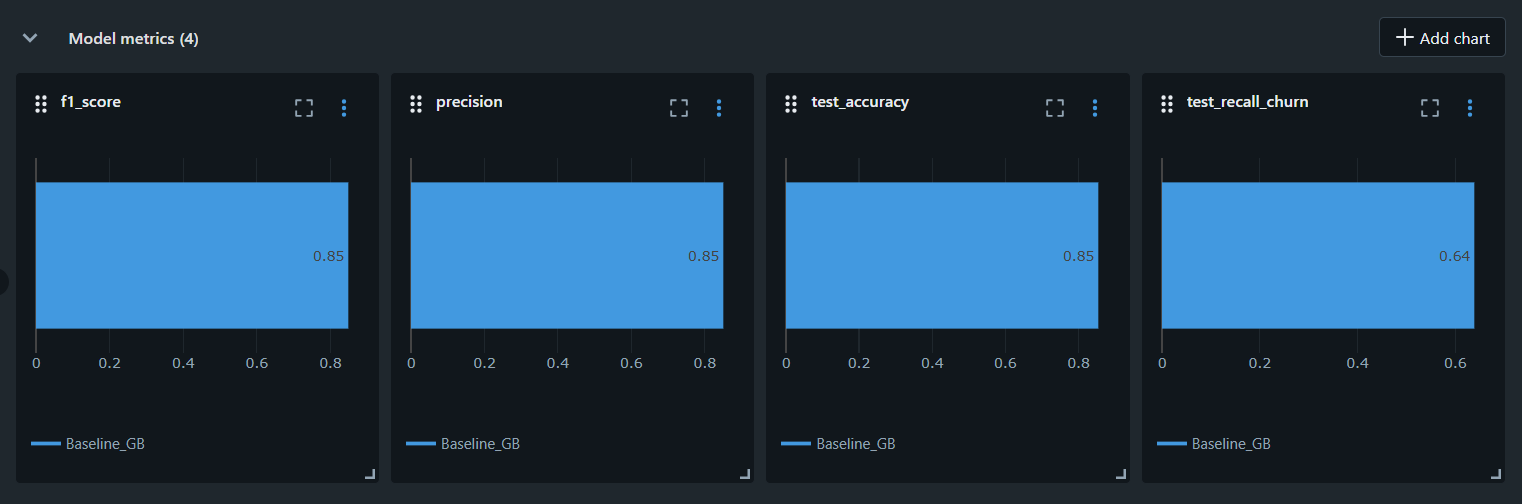

## Define hyperparameter search space
## Focus areas:
  - learning_rate: smaller values → better generalization
  - n_estimators: more trees → higher capacity (but risk overfitting)
  - max_depth: deeper trees → capture complex patterns
  - subsample: <1.0 → stochastic boosting (reduces overfitting)

## 8. Hyperparameter Search Space  
We define the full search grid for tuning the Gradient Boosting model using GridSearchCV.  
The search optimizes for recall (detecting churners).

## 9. Running GridSearchCV + Logging with MLflow  
We run a full hyperparameter tuning process using 3-fold cross-validation.  
The best model is evaluated and logged with MLflow, then registered for deployment.

In [36]:
# PART 2: Tuned Model (With GridSearchCV)
# Hyperparameter grid
param_grid = {
    'n_estimators': [100, 150, 200, 250],
    'learning_rate': [0.01, 0.02, 0.05, 0.1],
    'max_depth': [3, 4, 5, 6],
    'subsample': [0.8, 0.85, 0.9, 0.095],
    'min_samples_split': [2, 5, 10],             
    'min_samples_leaf': [1, 2, 4]    
}

with mlflow.start_run(run_name="Tuned_GB") as run2:
    # GridSearch
    grid = GridSearchCV(
        GradientBoostingClassifier(random_state=42),
        param_grid,
        cv=3,
        scoring='recall', 
        n_jobs=-1
    )
    grid.fit(X_train, y_train)
    
    best_gb_model = grid.best_estimator_
    
    # Predict & Evaluate
    y_pred = best_gb_model.predict(X_test)
    acc = accuracy_score(y_test, y_pred)
    rec = recall_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, average="weighted")
    f1 = f1_score(y_test, y_pred, average="weighted")

    # Log results
    mlflow.log_param("approach", "tuned_with_gridsearch")
    mlflow.log_params(grid.best_params_)
    mlflow.log_metric("cv_best_recall", grid.best_score_)
    mlflow.log_metric("test_accuracy", acc)
    mlflow.log_metric("test_recall_churn", rec)
    mlflow.log_metric("precision", precision)
    mlflow.log_metric("f1_score", f1)
    mlflow.sklearn.log_model(best_gb_model, "model")
    
    # Register model
    model_uri = f"runs:/{run2.info.run_id}/model"
    reg_result = mlflow.register_model(model_uri=model_uri, name=MODEL_NAME)
    version_tuned = reg_result.version
    
    # Set alias
    client.set_registered_model_alias(
        name=MODEL_NAME,
        alias="tuned",
        version=version_tuned
    )
    
    print(f"Tuned — Accuracy: {acc:0.2%} | Recall (Churn): {rec:0.2%}")
    print(f"Precision: {precision:0.2%}")
    print(f"F1 Score: {f1:0.2%}")
    print(f"Best CV Score (F1): {grid.best_score_:0.2%}")
    print(f"\nBest params: {grid.best_params_}")
    print(f"\nRegistered as version {version_tuned}, alias @tuned")

#print(f"Go to MLflow UI: http://127.0.0.1:5000")

2025/12/09 17:59:15 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/12/09 18:00:34 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
Registered model 'Churn_GradientBoosting__' already exists. Creating a new version of this model...
2025/12/09 18:00:42 WARNING mlflow.tracking._model_registry.fluent: Run with id 8d3247a0ac1847a5b4d38bf2f7ef458c has no artifacts at artifact path 'model', registering model based on models:/m-e34d57383ab640a996aff3afff68ed10 instead
2025/12/09 18:00:44 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: Churn_GradientBoosting__, version 13
Created version '13' of model 'Churn_GradientBoosting__'.


Tuned — Accuracy: 86.12% | Recall (Churn): 67.65%
Precision: 85.77%
F1 Score: 85.73%
Best CV Score (F1): 73.78%

Best params: {'learning_rate': 0.1, 'max_depth': 5, 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 150, 'subsample': 0.85}

Registered as version 13, alias @tuned
🏃 View run Tuned_GB at: http://127.0.0.1:5000/#/experiments/111232043532942513/runs/8d3247a0ac1847a5b4d38bf2f7ef458c
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/111232043532942513


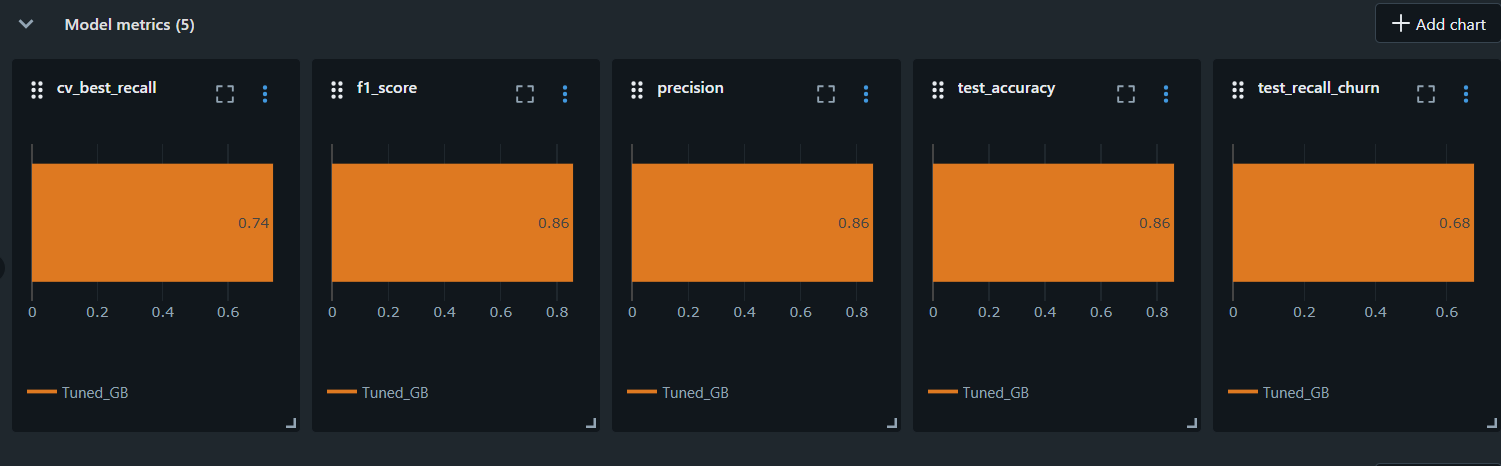